In [15]:
import math
import torch
from tqdm import tqdm
from typing import Tuple, Literal
from scipy.special import gammaln
import torch.nn as nn

import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

In [16]:

torch.manual_seed(42)

N = 100   # number of observations
L = 5     # number of features

# True weights
w_true = torch.tensor([1.5, -2.0, 0.5, 0.0, 1.0])
sigma_eps_true = 0.1

# Design matrix
Psi = torch.randn(N, L)

# Outputs
ys = Psi @ w_true + sigma_eps_true * torch.randn(N)

print("True weights:", w_true)
print("Shape of Psi:", Psi.shape)
print("Shape of y:", y.shape)

True weights: tensor([ 1.5000, -2.0000,  0.5000,  0.0000,  1.0000])
Shape of Psi: torch.Size([100, 5])
Shape of y: torch.Size([100])


In [17]:


def get_log_likelihood_closed_form(ys: torch.Tensor, 
                                   Psi: torch.Tensor,
                                   mu_w: torch.Tensor,  
                                   sigma_eps_sq: torch.Tensor, 
                                   sigma_w_sq: torch.Tensor, 
                                   N: int) -> torch.Tensor:
    pred_y = Psi @ mu_w
    log_likelihood = (
        - 0.5 * N * math.log(sigma_eps_sq) 
        - 0.5 * torch.sum((ys - pred_y) ** 2) / sigma_eps_sq
    )

    var_component = 0.5 * (1.0 / sigma_eps_sq) * torch.sum((Psi ** 2)* sigma_w_sq, dim=1)

    likelihood = torch.sum(log_likelihood) - torch.sum(var_component)
    return likelihood

In [18]:
def run_vi_closed_form(ys, Psi, num_iter, sigma_0_sq, sigma_eps_sq, lr):

    N, L = Psi.shape
    mu = nn.Parameter(torch.zeros(L, requires_grad=True))
    rho = nn.Parameter(torch.zeros(L, requires_grad=True))

    optimizer = torch.optim.Adam([mu, rho], lr=lr)
    elbos = []
    
    for _ in tqdm(range(num_iter)):
        optimizer.zero_grad()

        # transformation to ensure sigma is pos.
        sigma_w = torch.exp(rho) + 1e-5
        #sigma_w = torch.clamp(sigma_w, min=1e-4)
        
        # compute elbo in closed form
        log_likelihood = get_log_likelihood_closed_form(ys = ys, 
                                                        Psi = Psi, 
                                                        mu_w = mu, 
                                                        sigma_eps_sq = sigma_eps_sq, 
                                                        sigma_w_sq = sigma_w**2, N = N)
        kld = 0.5 * torch.sum(
            torch.log(sigma_0_sq / sigma_w**2) +
            (sigma_w**2 + mu**2) / sigma_0_sq -
            1
        )

        elbo = log_likelihood - .5* kld
        loss = - elbo

        loss.backward()
        optimizer.step()

        elbos.append(elbo.item())
    
    lambdas = {
            'mu': mu.detach(),
            'sigma': torch.exp(rho.detach()),
        }

    return lambdas, elbos


In [31]:
lambdas, elbos = run_vi_closed_form(ys = ys, Psi = Psi, num_iter = 10000, sigma_0_sq = .1**2, sigma_eps_sq = sigma_eps_true**2, lr = 1e-3)

100%|██████████| 10000/10000 [00:01<00:00, 5373.25it/s]


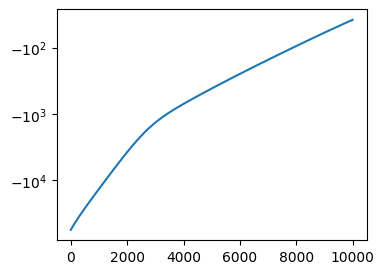

In [32]:
fig, axs = plt.subplots(1,1, figsize = (4,3))
axs.plot(elbos)
axs.set_yscale('symlog', base=10)

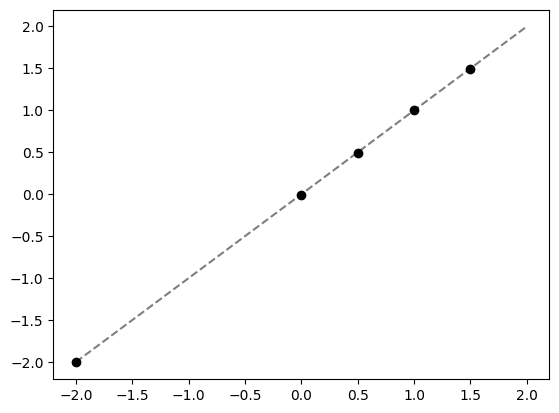

In [33]:
plt.scatter(w_true, lambdas['mu'], color = 'black')
plt.plot([-2,2], [-2,2], color ='black', alpha = .5, linestyle = 'dashed')